## Методи за прочистување на текст
1. Сите букви се сведуваат на мали букви
2. Се отстрануваат сите карактери што не се буква или празно место
3. Се отстрануваат сите евентуални двојни празни места
4. Се отстрануваат сите небитни зборови

In [8]:
import re

stopwords = [
    "a", "about", "above", "after", "again", "against", "all", "am", "an",
    "and", "any", "are", "as", "at", "be", "because", "been", "before",
    "being", "below", "between", "both", "but", "by", "could", "did", "do",
    "does", "doing", "down", "during", "each", "few", "for", "from", "further",
    "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her",
    "here", "here's", "hers", "herself", "him", "himself", "his", "how",
    "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it",
    "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself",
    "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours",
    "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll",
    "she's", "should", "so", "some", "such", "than", "that", "that's", "the",
    "their", "theirs", "them", "themselves", "then", "there", "there's",
    "these", "they", "they'd", "they'll", "they're", "they've", "this",
    "those", "through", "to", "too", "under", "until", "up", "very", "was",
    "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when",
    "when's", "where", "where's", "which", "while", "who", "who's", "whom",
    "why", "why's", "with", "would", "you", "you'd", "you'll", "you're",
    "you've", "your", "yours", "yourself", "yourselves"
]


def text_preproces(text):
    text = text.lower()  # to lowercase
    text = re.sub('[^a-zA-Z^ ]', '', text)  # keep text only
    text = re.sub(' +', ' ', text)  # remove extra spaces
    text = [word for word in text.split()
            if word not in stopwords]  # filter out stopwords
    #     text = [word for word in text if len(word) >= 3]
    return text


def tokenize(text):
    words = []
    words.extend(text)
    words = sorted(list(set(words)))
    return words

## Вчитување на фејлот и обработка
1. Се читаат сите линии од фајлот во листа
2. На секоја линија се прочистува текстот
3. Се додаваат нови параметри за должина на текстот и број на зборови

In [9]:
import csv


def loadCsv(filename):
    lines = csv.reader(open(filename, "r"))
    lines = list(lines)
    dataset = []
    for line in lines:
        row = line[0].split('\t')
        row.append(len(row[1]))  # text length
        row[1] = text_preproces(row[1])  # clean text
        row.append(len(row[1]))  # number of words
        row[1] = tokenize(row[1])  # tokenize words
        dataset.append(row)
    return dataset


dataset = loadCsv('SMSSpamTrain.txt')

## Метод за тренирање на класификаторот
1. Се двои податочното множество во речник со двете класи
2. Се пресметува појавување на секој збор во соодветната класа 
3. Се пресметува вкупниот број на уникатни зборови во класите

In [11]:
from collections import defaultdict


def train(dataset):
    separated = defaultdict(list)
    for row in dataset:
        separated[row[0]].append(row[1:])

    spam = defaultdict(lambda: 1)
    ham = defaultdict(lambda: 1)

    spam_lengths = defaultdict(lambda: 1)
    ham_lengths = defaultdict(lambda: 1)
    spam_word_lengths = defaultdict(lambda: 1)
    ham_word_lengths = defaultdict(lambda: 1)

    for sentence in separated['spam']:
        spam_lengths[sentence[1]] += 1
        spam_word_lengths[sentence[2]] += 1
        for word in sentence[0]:
            spam[word] += 1
    for sentence in separated['ham']:
        ham_lengths[sentence[1]] += 1
        ham_word_lengths[sentence[2]] += 1
        for word in sentence[0]:
            ham[word] += 1

    totalSpamWords = len(spam.keys())
    totalHamWords = len(ham.keys())
    print(totalSpamWords, totalHamWords)

    return spam, ham, totalSpamWords, totalHamWords, spam_lengths, ham_lengths


spam, ham, spamWords, hamWords, spam_lengths, ham_lengths = train(dataset)

1639 5631


## Метод за класифицирање на пораките
1. Се пресметува веројатноста зборот да е спам според формулата $$P(S|W) = \frac{P(W|S) \cdot P(S)}{P(W|S) \cdot P(S) + P(W|H) \cdot P(H)}$$
2. На истиот начин се пресметува веројатноста зборот да не е спам
3. Се пресметува вкупната веројатност пораката да е спам според формулата $$\eta = \sum_{1}^{n}[\ln(1-p_i) - \ln(p_i)]$$
$$p = \frac{1}{1+e^\eta}$$
4. Се пресметува вкупната веројатност пораката да не е спам според истата формула

In [12]:
import math


def classify(text, spam, ham, spamWords, hamWords, spam_lengths, ham_lengths):
    line = text[1]
    total = spamWords + hamWords

    probs_spam = []
    probs_ham = []
    for word in line:
        if (len(word) < 1):
            continue

        prob_word_spam = spam[word] / total
        prob_word_ham = ham[word] / total
        #         prob_spam = spamWords / total
        #         prob_ham = hamWords / total
        prob_spam = 0.5
        prob_ham = 0.5

        prob_spam_word = \
            (prob_word_spam * prob_spam) / \
            (prob_word_spam * prob_spam + prob_word_ham * prob_ham)

        prob_ham_word = \
            (prob_word_ham * prob_ham) /\
            (prob_word_spam * prob_spam + prob_word_ham * prob_ham)

        probs_spam.append(prob_spam_word)

        probs_ham.append(prob_ham_word)


#     total_lengths = spam_lengths[text[2]] + ham_lengths[text[2]]
#     probs_spam.append(spam_lengths[text[2]] / total_lengths)
#     probs_ham.append(ham_lengths[text[2]] / total_lengths)

#     from functools import reduce
#     import operator

#     print(probs_spam, probs_ham)

#     negs_spam = [1 - i for i in probs_spam]
#     prob_spam = reduce(operator.mul, probs_spam) / \
#         (reduce(operator.mul, probs_spam) + reduce(operator.mul, negs_spam))

#     negs_ham = [1 - i for i in probs_ham]
#     prob_ham = reduce(operator.mul, probs_ham) / \
#         (reduce(operator.mul, probs_ham) + reduce(operator.mul, negs_ham))

    eta = sum([math.log(1 - x) - math.log(x) for x in probs_spam])
    prob_spam = 1 / (1 + math.e**eta)

    eta = sum([math.log(1 - x) - math.log(x) for x in probs_ham])
    prob_ham = 1 / (1 + math.e**eta)

    return prob_spam, prob_ham

## Вчитување на тест множеството
1. За секоја линија во тест множеството се пресметува класата како поголемата веројатност помеѓу двете пресметани

In [13]:
test = loadCsv('SMSSpamTest.txt')
results = []
for line in test:
    s, h = classify(line, spam, ham, spamWords, hamWords, spam_lengths,
                    ham_lengths)
    results.append('spam' if (s > h) else 'ham')

## Прикажување на резултатите
1. Се пресметува confusion matrix
2. Се пресметува accuarcy score

0.9588900308324769

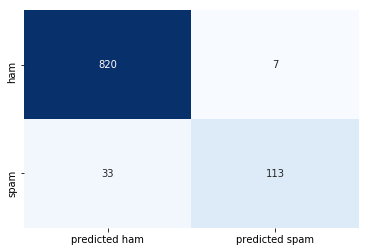

In [14]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd

classes_test = [t[0] for t in test]

cm = confusion_matrix(classes_test, results)
cm = pd.DataFrame(
    cm, index=['ham', 'spam'], columns=['predicted ham', 'predicted spam'])

sns.heatmap(cm, annot=True, cbar=False, fmt='d', cmap=plt.cm.Blues)

from sklearn.metrics import accuracy_score
accuracy_score(classes_test, results)